In [1]:
import drawSvg as draw
from enum import Enum
import math
strip =[]
stripwidth = 10
striplength=0
def render (strip, striplength, stripwidth):
    d = draw.Drawing(1000,stripwidth)
    for element in strip:
        if type(element) is Plain:
            striplength += element.length
    d.append(draw.Rectangle(0, 0, striplength, stripwidth,stroke='red', fill='none'))        
    d.saveSvg('test.svg')
    d.rasterize()
    return d

In [2]:
class Plain:
    def __init__(self, length):
        self.length = length
def addPlain(strip,len):
    strip.append(Plain(len))
    return strip

strip = addPlain(strip,100)
render (strip, striplength, stripwidth)

In [3]:
class Fold:
    def __init__(self, mv, angle):
        self.mv = mv
        self.angle = angle
    def getLength(self,stripwidth):
        return stripwidth*math.tan(math.radians(90-self.angle))
class MV(Enum):
    MOUNTAIN=0
    VALLEY=1 
def addFold(strip,mv,angle):
    strip.append(Fold(mv,angle))
    return strip
 
def render (strip, striplength, stripwidth):
    d = draw.Drawing(1000,stripwidth)
    for element in strip:
        if type(element) is Plain:
            striplength += element.length
        if type(element) is Fold:
            l = element.getLength(stripwidth)
            x1 = striplength 
            x2 = striplength+abs(l) 
            if l <0: x1,x2 = x2,x1
            d.append(draw.Line(x1,0,x2,stripwidth,stroke='red' if element.mv is MV.MOUNTAIN else 'blue', fill='none'))    
            striplength += abs(l)
    d.append(draw.Rectangle(0, 0, striplength, stripwidth,stroke='red', fill='none'))        
    d.saveSvg('test.svg')
    d.rasterize()
    return d

strip = addFold(strip,MV.MOUNTAIN, -45)
strip = addFold(strip,MV.MOUNTAIN, 45)
strip = addPlain(strip,100)
strip = addFold(strip,MV.VALLEY, -30)

render (strip, striplength, stripwidth)

In [4]:
def addCornerGadget (strip,mv):
    strip = addFold(strip,mv,45)
    strip = addFold(strip,mv,-45)
    return strip
strip = addCornerGadget(strip,MV.MOUNTAIN)
render (strip, striplength, stripwidth)

In [6]:
class Direction(Enum):
    L=-1
    R=1 
def addCornerGadget (strip,mv,d):
    strip = addFold(strip,mv,45*d.value)
    strip = addFold(strip,mv,-45*d.value)
    return strip
strip = addCornerGadget(strip,MV.MOUNTAIN,Direction.R)
strip = addPlain(strip,100)
strip = addCornerGadget(strip,MV.MOUNTAIN,Direction.L)
render (strip, striplength, stripwidth)

[(0.0, 0.0), (10.0, 0.0), (10.0, 10.0), (0.0, 0.0)]


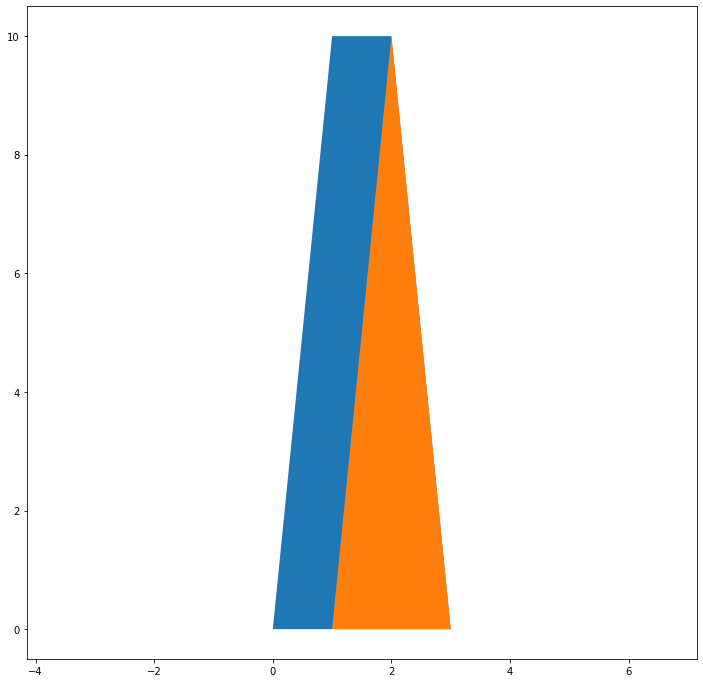

In [15]:
from shapely.geometry import Polygon
from matplotlib import pyplot as plt

triangle = Polygon([(0,0),(10,0),(10,10)])
plt.figure(figsize=(12, 12))
plt.axis('equal')
print(list(zip(*triangle.exterior.coords.xy)))
plt.fill([(0.0, 0.0), (10.0, 0.0), (10.0, 10.0), (0.0, 0.0)])
plt.show()
